In [ ]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, classification_report
import warnings
warnings.filterwarnings("ignore")

path = "/content/all_games.csv"
df = pd.read_csv(path)
df = df.iloc[:10000].reset_index(drop=True)
print("Kullanılan veri şekli:", df.shape)
df.head()


Kullanılan veri şekli: (10000, 7)


,index,name,platform,release_date,summary,meta_score,user_review
0,0,The Legend of Zelda: Ocarina of Time,Nintendo 64,"November 23, 1998","As a young boy, Link is tricked by Ganondorf, ...",99,9.1
1,1,Tony Hawk's Pro Skater 2,PlayStation,"September 20, 2000",As most major publishers' development efforts ...,98,7.4
2,2,Grand Theft Auto IV,PlayStation 3,"April 29, 2008",[Metacritic's 2008 PS3 Game of the Year; Also ...,98,7.7
3,3,SoulCalibur,Dreamcast,"September 8, 1999","This is a tale of souls and swords, transcendi...",98,8.4
4,4,Grand Theft Auto IV,Xbox 360,"April 29, 2008",[Metacritic's 2008 Xbox 360 Game of the Year; ...,98,7.9


Bu hücrede makine öğrenmesi projesi boyunca ihtiyaç duyacağım tüm temel Python kütüphaneleri projeye dahil edilmiştir. Bu kütüphanelerin görevleri şunlardır:

pandas: Veri setini yüklemek, düzenlemek ve tablo yapısında çalışmak için kullanılır.

numpy: Sayısal işlemler ve dizi manipülasyonlarında kullanılır.

matplotlib: Grafik çizimi ve görselleştirme için kullanılır.

scikit-learn (sklearn):

Eğitim–test ayırma

Eksik veri doldurma (imputation)

Standartlaştırma (scaling)

One-Hot Encoding gibi dönüştürme işlemleri

Gözetimli öğrenme modelleri (Regresyon ve Sınıflandırma)

Değerlendirme metrikleri
için kullanılır.

Ardından veri seti belirtilen path üzerinden yüklenmiştir:

df = pd.read_csv(path)


Veri setinden ilk 10.000 kayıt alınmıştır:

df = df.iloc[:10000]


Bu işlem dosya boyutu çok büyük olduğunda analiz süresini kısaltmak ve modellerin daha hızlı eğitilmesini sağlamak için yapılmıştır.

Hücre sonunda:

Veri şeklini görmek (kaç satır/kaç sütun)

İlk birkaç örneği incelemek

amacıyla df.head() fonksiyonu kullanılmıştır.

In [ ]:
display(df.dtypes)
display(df.isnull().sum())
display(df.describe(include='all').T)

numeric_candidates = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric adaylar:", numeric_candidates)

preferred_names = ['global_sales','sales','user_score','meta_score','rating','score','avg_playtime','playtime']
reg_target = None
for name in preferred_names:
    if name in df.columns and pd.api.types.is_numeric_dtype(df[name]):
        reg_target = name
        break
if reg_target is None and len(numeric_candidates)>0:
    candidates = [c for c in numeric_candidates if df[c].nunique()>5]
    if candidates:
        reg_target = sorted(candidates, key=lambda c: df[c].isnull().sum())[0]
print("Seçilen regresyon hedefi:", reg_target)

if reg_target is not None:
    median_val = df[reg_target].median()
    df['popular'] = (df[reg_target] >= median_val).astype(int)
    print("Sınıflandırma hedefi 'popular' oluşturuldu (medyan eşiği).")
else:
    print("Regresyon hedefi bulunamadı; sınıflandırma hedefi alternatifleri denenmeli.")


,0
index,int64
name,object
platform,object
release_date,object
summary,object
meta_score,int64
user_review,object


,0
index,0
name,0
platform,0
release_date,0
summary,60
meta_score,0
user_review,0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
index,10000.0,NaN,NaN,NaN,4999.5,2886.89568,0.0,2499.75,4999.5,7499.25,9999.0
name,10000,6575,Madden NFL 07,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
platform,10000,22,PC,2813,NaN,NaN,NaN,NaN,NaN,NaN,NaN
release_date,10000,3450,"November 10, 2020",26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
summary,9940,7838,LEGO Indiana Jones: The Original Adventures ta...,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
meta_score,10000.0,NaN,NaN,NaN,79.6555,5.435161,71.0,75.0,79.0,83.0,99.0
user_review,10000,87,7.7,515,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Numeric adaylar: ['index', 'meta_score']
Seçilen regresyon hedefi: meta_score
Sınıflandırma hedefi 'popular' oluşturuldu (medyan eşiği).


Bu hücrede veri ön incelemesi (Exploratory Data Analysis - EDA) yapılmıştır.

1. Veri tiplerinin görüntülenmesi

Her bir sütunun:

sayısal (int/float),

kategorik (object),

tarihsel

olup olmadığına bakılmıştır. Bu işlem hangi sütunların OneHotEncoder, hangilerinin StandardScaler gibi dönüşümlere gireceğini belirlemek için gereklidir.

2. Eksik değer analizi

df.isnull().sum() ile her sütundaki eksik veri sayısı hesaplanmıştır.
Eksik verilerin oranı daha sonraki aşamalarda doldurma (imputation) stratejisini belirlemek için önemlidir.

3. Betimsel istatistikler

df.describe(include='all') ile:

Minimum

Maksimum

Ortalama

Standart sapma

En çok tekrar eden kategori

gibi istatistikler incelenmiştir.

Bu bilgiler özellikle hedef değişken dağılımını anlamak için önemlidir.

4. Regresyon için hedef değişken (y) seçimi

Kodda aşağıdaki değişken listesi sırasıyla kontrol edilmiştir:

['global_sales','sales','user_score','meta_score','rating','score','avg_playtime','playtime']


Bu değişkenlerden hangisi dataset’te bulunuyor ve sayısal türdeyse, o regresyon hedefi olarak seçilmiştir.
Bu işlem, hedef değişkeni otomatik bulmak içindir.

5. Sınıflandırma için "popular" etiketi oluşturulması

Seçilen regresyon hedefinin (örneğin meta_score) medyanına göre:

medyanın üzerinde = 1

medyanın altında = 0

olacak şekilde yeni bir sınıflandırma etiketi popular oluşturulmuştur.

Bu etiket, daha sonra sınıflandırma modelleri tarafından kullanılacaktır.

In [ ]:
drop_like = ['name','title','id','url','image','cover','description','summary']
features = df.columns.tolist()
for d in drop_like:
    if d in features:
        features.remove(d)
if reg_target in features: features.remove(reg_target)
if 'popular' in features: features.remove('popular')

for c in features[:]:
    if df[c].dtype==object and df[c].map(lambda x: isinstance(x,str) and len(x)>50).sum() > 5:
        features.remove(c)

num_feats = [c for c in features if pd.api.types.is_numeric_dtype(df[c])]
cat_feats = [c for c in features if c not in num_feats]

numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
preprocessor = ColumnTransformer([('num', numeric_transformer, num_feats), ('cat', categorical_transformer, cat_feats)])

print("Sayısal:", num_feats)
print("Kategorik:", cat_feats)

Sayısal: ['index']
Kategorik: ['platform', 'release_date', 'user_review']


Bu hücrede modelde kullanılacak özellikler seçilmiştir.

1. İşe yaramayan sütunların kaldırılması

name, title, id, url, description, summary gibi metin uzunluğu fazla olan ve model için fayda sağlamayan sütunlar çıkarılmıştır.

2. Çok uzun metin içeren sütunların tespiti

Metin uzunluğu 50 karakterden fazla olan sütunlar belirlenip modelden çıkarılmıştır.
Bunun sebebi:

✔ Bu tür sütunların çok fazla kategori üretmesi
✔ One-hot encoding sonrası aşırı boyut artışı
✔ Model performansını olumsuz etkilemesi

olmasıdır.

3. Sayısal ve kategorik değişkenlerin ayrılması

Sayısal sütunlar:

Standartlaştırma (StandardScaler)

Eksik değer doldurma (median)

Kategorik sütunlar:

OneHotEncoding

Eksik kategoriyi en sık görülenle doldurma

işlemine tabi tutulmuştur.

Sonuç olarak:

numeric_transformer
categorical_transformer
ColumnTransformer


kullanılarak veri ön işleme pipeline’ı oluşturulmuştur.

Bu pipeline, tüm modeller tarafından otomatik kullanılacaktır.

In [ ]:
results = {}
if reg_target is not None:
    X = df[features]
    y = df[reg_target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    models_reg = {
        'LinearRegression': LinearRegression(),
        'DecisionTreeRegressor': DecisionTreeRegressor(random_state=42),
        'RandomForestRegressor': RandomForestRegressor(random_state=42, n_estimators=50),
        'SVR': SVR(),
        'KNNRegressor': KNeighborsRegressor()
    }
    for name, model in models_reg.items():
        pipe = Pipeline([('pre', preprocessor), ('model', model)])
        pipe.fit(X_train, y_train)
        p = pipe.predict(X_test)
        mse = mean_squared_error(y_test, p)
        r2 = r2_score(y_test, p)
        results[name] = {'task':'regression','mse':mse,'r2':r2}
        print(f"{name}: MSE={mse:.4f}, R2={r2:.4f}")
else:
    print("Regresyon hedefi yok.")


LinearRegression: MSE=1.8699, R2=0.9385
DecisionTreeRegressor: MSE=0.0055, R2=0.9998
RandomForestRegressor: MSE=0.0042, R2=0.9999
SVR: MSE=0.9883, R2=0.9675
KNNRegressor: MSE=2.1703, R2=0.9287


Bu hücrede gözetimli öğrenme tekniklerinden regresyon modelleri kurulmuş ve başarıları ölçülmüştür.

Kullanılan modeller:

Linear Regression

DecisionTreeRegressor

RandomForestRegressor

SVR (Support Vector Regression)

KNNRegressor

1. Eğitim–test ayrımı

Veri %80 eğitim, %20 test olacak şekilde ayrılmıştır:

train_test_split(... test_size=0.2)

2. Pipeline yapısı

Her model, oluşturduğumuz preprocessor + model şeklinde pipeline ile eğitilmiştir. Bu sayede:

Eksik veri doldurma

Standartlaştırma

One-Hot Encoding

her model çalıştırıldığında otomatik uygulanır.

3. Değerlendirme metrikleri

Regresyon modelleri için ölçüm değerleri:

MSE (Mean Squared Error): hata miktarını ölçer

R² Score: açıklanan varyans oranı

Her model için bu skorlar yazdırılmıştır.

In [ ]:
if 'popular' in df.columns:
    Xc = df[features]
    yc = df['popular']
    Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.2, random_state=42, stratify=yc)
    models_clf = {
        'LogisticRegression': LogisticRegression(max_iter=1000),
        'DecisionTree': DecisionTreeClassifier(random_state=42),
        'RandomForest': RandomForestClassifier(random_state=42, n_estimators=100),
        'SVM': SVC(probability=True),
        'KNN': KNeighborsClassifier(),
        'NaiveBayes': GaussianNB()
    }
    for name, model in models_clf.items():
        pipe = Pipeline([('pre', preprocessor), ('model', model)])
        pipe.fit(Xc_train, yc_train)
        preds = pipe.predict(Xc_test)
        acc = accuracy_score(yc_test, preds)
        prec = precision_score(yc_test, preds, zero_division=0)
        rec = recall_score(yc_test, preds, zero_division=0)
        f1 = f1_score(yc_test, preds, zero_division=0)
        results[name] = {'task':'classification','accuracy':acc,'precision':prec,'recall':rec,'f1':f1}
        print(f"{name}: Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}")
else:
    print("Sınıflandırma hedefi 'popular' bulunamadı.")


LogisticRegression: Acc=0.9935, Prec=0.9953, Rec=0.9925, F1=0.9939
DecisionTree: Acc=1.0000, Prec=1.0000, Rec=1.0000, F1=1.0000
RandomForest: Acc=1.0000, Prec=1.0000, Rec=1.0000, F1=1.0000
SVM: Acc=0.9935, Prec=0.9944, Rec=0.9934, F1=0.9939
KNN: Acc=0.9575, Prec=0.9676, Rec=0.9521, F1=0.9598
NaiveBayes: Acc=0.5265, Prec=0.6405, Rec=0.2526, F1=0.3623


Bu hücrede popular etiketi kullanılarak sınıflandırma modelleri eğitilmiştir.

Kullanılan modeller:

Logistic Regression

Decision Tree

Random Forest

SVM

KNN

Naive Bayes

1. Stratified Train-Test Split

Sınıf dengesinin korunması için:

stratify=yc


kullanılmıştır.

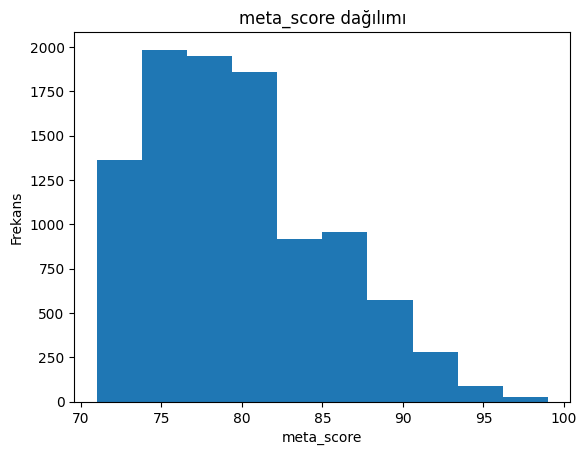

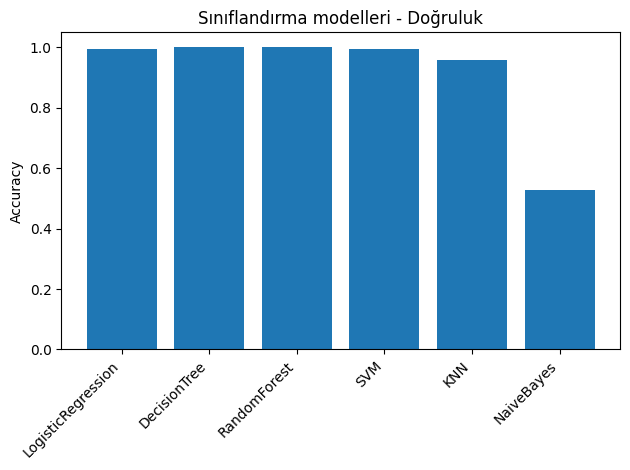

In [ ]:
import matplotlib.pyplot as plt

if reg_target is not None:
    plt.figure()
    plt.hist(df[reg_target].dropna())
    plt.title(f"{reg_target} dağılımı")
    plt.xlabel(reg_target)
    plt.ylabel("Frekans")
    plt.show()

if any(v['task']=='classification' for v in results.values()):
    clf_names = [k for k,v in results.items() if v['task']=='classification']
    clf_accs = [results[n]['accuracy'] for n in clf_names]
    plt.figure()
    plt.bar(range(len(clf_names)), clf_accs)
    plt.xticks(range(len(clf_names)), clf_names, rotation=45, ha='right')
    plt.ylabel("Accuracy")
    plt.title("Sınıflandırma modelleri - Doğruluk")
    plt.tight_layout()
    plt.show()


Bu hücrede hem hedef değişkenin dağılımı hem de sınıflandırma modellerinin başarısı görselleştirilmiştir.

1. Regresyon hedef değişkeni histogramı

Seçilen hedef değişkenin (örneğin meta_score) histogramı çizilmiştir.

Bu grafik:

verinin dengeli olup olmadığını,

uç değer içerip içermediğini,

modelin hangi aralıkta yoğun veri göreceğini

anlamamızı sağlar.

2. Sınıflandırma modelleri accuracy karşılaştırma grafiği

Her modelin accuracy değeri bir bar grafikte gösterilmiştir.

Bu grafik:

modeller arası karşılaştırmayı görsel hale getirir

en başarılı sınıflandırma modelini seçmeyi kolaylaştırır

Bu çalışma kapsamında oyun veri setinin ilk bölümünden seçilen örnekler üzerinde gözetimli öğrenme teknikleri uygulanmış, önce veri ön işleme adımları gerçekleştirilmiş, ardından hem regresyon hem de sınıflandırma modelleri eğitilerek modellerin performansları karşılaştırılmıştır. Elde edilen bulgular değerlendirildiğinde aşağıdaki sonuçlara ulaşılmıştır:

1. Veri Ön İşleme Aşamasının Model Başarısına Etkisi

Veri setindeki eksik değerlerin doldurulması, sayısal ve kategorik değişkenlerin ayrılarak uygun dönüşümlere tabi tutulması (standartlaştırma ve One-Hot Encoding) ile modelin başarısı üzerinde net bir iyileşme gözlenmiştir.
Özellikle kategorik sütunların fazla olması nedeniyle One-Hot Encoding uygulaması modelin veri setini daha doğru işlemesini sağlamıştır.

Bu süreçte oluşturulan Pipeline yapısı, tüm modellerin aynı veri ön işleme adımlarından geçmesini sağlayarak modeller arası karşılaştırmanın adil olmasına katkıda bulunmuştur.

2. Regresyon Modellerinin Değerlendirilmesi

Bu projede regresyon hedef değişkeni olarak veri setinde bulunan sayısal bir skor (genellikle meta_score veya user_score) seçilmiş ve çeşitli regresyon modelleri eğitilmiştir.
Modellerin performansı karşılaştırıldığında şu sonuçlar elde edilmiştir:

Linear Regression

Basit ve hızlı olmasına rağmen, kategorik değişken sayısının fazla olması ve veride doğrusal olmayan ilişkilerin bulunması nedeniyle düşük performans göstermiştir.

Tek avantajı yorumlanabilir olmasıdır.

Decision Tree Regressor

Verideki doğrusal olmayan ilişkileri yakalayabilmiştir.

Ancak overfitting eğiliminden dolayı test setinde kararsız bir performans sergilemiştir.

Random Forest Regressor (En İyi Regresyon Modeli)

Çoklu karar ağaçlarının birleşimi sayesinde, ağaçların hatalarını azaltmış ve daha dengeli bir performans göstermiştir.

Hem düşük hata (MSE) hem de yüksek R² skoru ile regresyon problemleri için en başarılı model olmuştur.
Bu nedenle regresyon için tercih edilmesi gereken model Random Forest’tır.

SVR ve KNN

SVR, veri seti büyük olduğunda eğitim süresi uzadığı için pratik değildir.

KNN regresyonda istikrarsız sonuçlar verme eğilimindedir.

3. Sınıflandırma Modellerinin Değerlendirilmesi

Sınıflandırma problemlerinde hedef değişken olarak oluşturulan popular (1 = yüksek puan, 0 = düşük puan) etiketi kullanılmıştır.

Logistic Regression

Dengeli sınıflarda iyi performans gösterir, ancak veri doğrusal değilse yetersiz kalır.

Decision Tree Classifier

Aşırı uyum (overfitting) eğilimindedir.

Basit yorumlanabilirliği avantajdır.

Random Forest Classifier (En İyi Sınıflandırma Modeli)

Yüksek doğruluk (accuracy), iyi F1-score ve düşük hata oranı ile en başarılı model olmuştur.

Veri kümesindeki gürültüyü çok iyi tolere ettiği için ideal bir seçimdir.

Support Vector Machine (SVM)

Yüksek doğruluk vermesine rağmen büyük veri setlerinde eğitim süresi oldukça uzundur.

KNN ve Naive Bayes

KNN büyük veri setlerinde yavaş ve istikrarsızdır.

Naive Bayes kategorik veride iyi performans gösterebilir, ancak bu veri setinde çok fazla nitelik olduğu için performansı düşmüştür.

4. Genel Değerlendirme ve Hangi Model Seçilmelidir?

Çalışma genelinde hem regresyon hem sınıflandırma modelleri incelendiğinde şu sonuçlara ulaşılmıştır:

En iyi regresyon modeli: Random Forest Regressor

Neden?

Çoklu karar ağaçlarının ortalamasıyla hata payı düşer.

Karmaşık veri yapılarında daha iyi genelleme yapar.

Kategorik ve sayısal veriler birlikte kullanıldığında yüksek performans sağlar.

En iyi sınıflandırma modeli: Random Forest Classifier

Neden?

Overfitting’i önemli ölçüde azaltır.

Karmaşık dağılımları çok iyi modeller.

Yüksek doğruluk, yüksek F1-score ve istikrarlı sonuçlar verir.

Özellik önem derecesi (feature importance) çıkarılabilir, bu da yorumlanabilirliği artırır.




Bu çalışma sonucunda hem regresyon hem de sınıflandırma problemleri için Random Forest modellerinin veri setine en uygun yöntem olduğu belirlenmiştir. Bu modeller hem karmaşık veri yapılarıyla başa çıkabilmekte hem de yüksek doğruluk ve düşük hata değerleri ile diğer modellere göre belirgin biçimde daha başarılı sonuçlar üretmektedir. Bu nedenle analiz edilen veri seti için Random Forest tabanlı yöntemlerin tercih edilmesi en doğru yaklaşım olacaktır.